# Global (Imports, Constants, Utils etc) 



## GPU type

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Apr 23 20:46:33 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| 32%   40C    P2    43W / 170W |  12001MiB / 12045MiB |      7%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Module & Goggle Drive import

In [2]:
try:
  from google.colab import drive
  drive.mount('/content/drive')
  !pip install keras_tuner
except:
  pass

In [3]:
import os
import sys
import tensorflow as tf
import tensorflow.keras as keras
import keras_tuner as kt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.signal import savgol_filter
from tqdm.notebook import trange, tqdm
from pickle import (
    dump,
    load
)

from tensorflow.keras import (
    layers,
    Model,
    Sequential,
    optimizers
)
from tensorflow.keras.preprocessing.sequence import (
    pad_sequences    
)

from pprint import pprint
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer



## Constant definision

In [4]:
# If runs on google colab or not
try:
  import google.colab
  BASE_DIR = "/content/drive/MyDrive/Colab Notebooks/drone_research"
except:
  BASE_DIR = "/home/israzex/Desktop/drone_homecoming_rl/artificial_gps"

DATA_FOLDER_NAME = "data"
DATA_FOLDER_PATH = os.path.join(BASE_DIR, DATA_FOLDER_NAME)
MODELS_FOLDER_NAME = "models"
MODELS_FOLDER_PATH = os.path.join(BASE_DIR, MODELS_FOLDER_NAME)
TUNERS_FOLDER_NAME = "tuners"
TUNERS_FOLDER_PATH = os.path.join(BASE_DIR, TUNERS_FOLDER_NAME)


# OUTPUT_DATA_COLUMNS = ["position_x", "position_y", "position_z"]


INPUT_COLUMNS = ["linear_velocity_x", "linear_velocity_y",
                          "angular_acceleration_x", "angular_acceleration_y", "angular_acceleration_z",
                          "linear_acceleration_x", "linear_acceleration_y", "linear_acceleration_z",
                          "angular_velocity_x", "angular_velocity_y", "angular_velocity_z",
                          "orientation_x", "orientation_y", "orientation_z", "orientation_w", "motor_state_timestamp",
                          "barometer_altitude", "barometer_pressure", 
                          "barometer_qnh", 
                          "barometer_timestamp",                          
                         ]
OUTPUT_COLUMNS = ["position_x", "position_y"]

ACCELOMETER_SENSORS = ["linear_velocity_x", "linear_velocity_y", "linear_velocity_z",
                       "angular_acceleration_x", "angular_acceleration_y", "angular_acceleration_z",
                       "linear_acceleration_x", "linear_acceleration_y", "linear_acceleration_z",
                       "angular_velocity_x", "angular_velocity_y", "angular_velocity_z"]
ORIENTATION_SENSORS = ["orientation_x", "orientation_y", "orientation_z", "orientation_w"]
MAGNOMETER_SENSORS = ["magnetometer_magnetic_field_body_x", 
                      "magnetometer_magnetic_field_body_y",
                      "magnetometer_magnetic_field_body_z"]
BAROMETER_SENSORS = ["barometer_altitude", "barometer_pressure", "barometer_qnh"]
ROTOR_SENSORS = ["rotor_a_speed", "rotor_a_thrust", "rotor_a_torque_scaler",
                 "rotor_b_speed", "rotor_b_thrust", "rotor_b_torque_scaler",
                 "rotor_c_speed", "rotor_c_thrust", "rotor_c_torque_scaler",
                 "rotor_d_speed", "rotor_d_thrust", "rotor_d_torque_scaler"]

TIMESTAMP_COLUMNS = ["motor_state_timestamp", "barometer_timestamp", 
                     "magnetometer_timestamp", "rotor_timestamp"]


MAIN_TIMESTAMP_COLUMN = "motor_state_timestamp"
INPUT_SEQUENCE_LENGTH = 10


In [5]:
def get_recordings_files():
    all_csv_files = os.listdir(DATA_FOLDER_PATH)

    all_csv_files.remove("bot-train-1_23Apr_18:24_record.csv")
    return all_csv_files


In [6]:
# Set float 64
tf.keras.backend.set_floatx('float32')

## Utils


### Save and Load models

In [7]:
def save_model_with_scalers_binary(model, scaler_x, scaler_y, model_name: str):
    """
    Saves models with the x, y scaler objects to a binary library using pickle library
    """
    model_file_name = f"{model_name}_model.pkl"
    model_file_path = os.path.join(MODELS_FOLDER_PATH, model_file_name)
    scaler_x_file_name = f"{model_name}_scaler_x.pkl"
    scaler_x_file_path = os.path.join(MODELS_FOLDER_PATH, scaler_x_file_name)
    scaler_y_file_name = f"{model_name}_scaler_y.pkl"
    scaler_y_file_path = os.path.join(MODELS_FOLDER_PATH, scaler_y_file_name)

    with open(model_file_path, "wb") as file:
        dump(model, file)

    with open(scaler_x_file_path, "wb") as file:
        dump(scaler_x, file)

    with open(scaler_y_file_path, "wb") as file:
        dump(scaler_y, file)
        
def load_model_with_scalers_binary(model_name: str):
    """
    Saves models with the x, y scaler objects to a binary library using pickle library
    """
    model_file_name = f"{model_name}_model.pkl"
    model_file_path = os.path.join(MODELS_FOLDER_PATH, model_file_name)
    scaler_x_file_name = f"{model_name}_scaler_x.pkl"
    scaler_x_file_path = os.path.join(MODELS_FOLDER_PATH, scaler_x_file_name)
    scaler_y_file_name = f"{model_name}_scaler_y.pkl"
    scaler_y_file_path = os.path.join(MODELS_FOLDER_PATH, scaler_y_file_name)

    with open(model_file_path, "rb") as file:
        model = load(file)

    with open(scaler_x_file_path, "rb") as file:
        scaler_x = load(file)

    with open(scaler_y_file_path, "rb") as file:
        scaler_y = load(file)

    return model, scaler_x, scaler_y

## Data Split

In [8]:
def split_data(data: np.array, train_per = 0.95, dev_per= 0.5):
    """
    Splits data into train, dev and test
    :return:
    """
    data_len = len(data)

    train, dev, test = np.split(data, [int(train_per * data_len),
                                       int((dev_per + train_per) * data_len)])

    return train, dev, test


### Shuffle dataset

In [9]:
def shuffle_data_set(x_data: np.array, y_data: np.array):
    example_amount = x_data.shape[0]
    shuffle_indexes = np.random.permutation(example_amount)
    
    x_data = x_data[shuffle_indexes]
    y_data = y_data[shuffle_indexes]

    return x_data, y_data

# Data Preprocessing

### Load from single file

In [10]:
# Loads data from recording file
# Converts timestamp -> time offset from last timestamp
#          location  -> step made from last location in x time offset

def _convert_timestamp_to_interval_seconds(flight_input_df: pd.DataFrame, timestamp_columns: list):
    """
    Converts the timestamp fields into the amount of seconds between each two timestamps

    Note: each timestamp represents the amount eof NANO seconds (1,000,000,000 nanoseconds = 1 seconds)
    """
    # Converts the start time to time interval
    next_time_df = flight_input_df[timestamp_columns].shift(-1)
    time_diff_df = (next_time_df - flight_input_df[timestamp_columns]) / 1_000_000_000
    flight_input_df.loc[:, timestamp_columns] = time_diff_df
    return flight_input_df

def _convert_position_to_step(flight_output_df: pd.DataFrame):
    next_position_df = flight_output_df.shift(-1)
    position_diff = flight_output_df - next_position_df

    return position_diff
    
def load_flight_steps_from_file(csv_name: str, input_columns: list, output_columns: list):
    """

    @param csv_name:
    @param input_columns:
    @param output_columns:
    @return:
    """
    if not csv_name.endswith("csv"):
        raise ValueError(f"File with unsupported extension, expected csv (file: {csv_name})")

    csv_path = os.path.join(DATA_FOLDER_PATH, csv_name)
    flight_df = pd.read_csv(csv_path)

    x_df = flight_df[input_columns].copy()
    timestamp_columns = [column for column in input_columns if column in TIMESTAMP_COLUMNS]
    x_df = _convert_timestamp_to_interval_seconds(x_df, timestamp_columns)

    y_df = flight_df[output_columns].copy()
    y_df = _convert_position_to_step(y_df)
    
    # Drops the last record because the process is based of difference
    x_df.drop(x_df.tail(1).index, inplace=True)
    y_df.drop(y_df.tail(1).index, inplace=True)

    return x_df, y_df

In [11]:
def load_dataset(input_columns: list, output_columns: list):
    """
    Loads flight steps and orders it to sequences of sequence_length length.
    In order to feed it to rnn/lstm s2s model

    @param input_columns: The input columns
    @param output_columns: The outputs columns
    @return:
    """
    all_csv_files = get_recordings_files()

    # x, y data from all flight sessions
    x_sessions = []
    y_sessions = []

    for csv_name in all_csv_files:
        try:
            x_df, y_df = load_flight_steps_from_file(csv_name, input_columns, output_columns)

            x_sessions.append(x_df)
            y_sessions.append(y_df)

        except ValueError as error:
            print(str(error))

    x_df = pd.concat(x_sessions, ignore_index=True)
    y_df = pd.concat(y_sessions, ignore_index=True)

    return x_df, y_df


### Preprocess data

In [12]:
def preprocess_ann_dataset(x_df: pd.DataFrame, y_df : pd.DataFrame):
    # scaler_x = ColumnTransformer([
    #       ("rotor_sensors", StandardScaler(), ["rotor_a_speed", "rotor_b_speed",
    #                                         "rotor_c_speed", "rotor_d_speed"]),
    #       ("accelerator_values", MinMaxScaler((-1,1)), ACCELOMETER_SENSORS),
    #       ("orientation", MinMaxScaler((-1,1)), ORIENTATION_SENSORS),
    #       ("barometer", MinMaxScaler(), BAROMETER_SENSORS),
    #       ("magnetometer_x_y", MinMaxScaler((-1,1)),["magnetometer_magnetic_field_body_x", 
    #                                        "magnetometer_magnetic_field_body_y"]),
    #       ("magnetometer_z", MinMaxScaler(),["magnetometer_magnetic_field_body_z"]),                      
    #       ("rotors_other", MinMaxScaler(),["rotor_a_thrust", "rotor_a_torque_scaler",
    #                                        "rotor_b_thrust", "rotor_b_torque_scaler",
    #                                        "rotor_c_thrust", "rotor_c_torque_scaler",
    #                                        "rotor_d_thrust", "rotor_d_torque_scaler",]),
    #       ],
    #       remainder='passthrough')
    
    scaler_y = MinMaxScaler()
    scaler_x = MinMaxScaler((-1,1))
    data_x = scaler_x.fit_transform(x_df)

    data_y = y_df.to_numpy()
    data_y = scaler_y.fit_transform(data_y)

    data_x = data_x.astype(np.float32)
    data_y = data_y.astype(np.float32)
    return data_x, data_y, scaler_x, scaler_y

In [13]:
def load_preprocessed_dataset(input_columns: list, output_columns: list):
    """
    Loads the whole dataset with preprocessing

    @param input_columns: Input columns names
    @param output_columns: Output columns names
    @param sequence_length: The size of input x sequence
    @return: Loaded, preprocessed, shuffled, splitted data set
    """
    x_data, y_data = load_dataset(input_columns, output_columns)
    x_data, y_data, scaler_x, scaler_y = preprocess_ann_dataset(x_data, y_data)

    train_x, dev_x, test_x = split_data(x_data, train_per=0.88, dev_per=0.12)
    train_y, dev_y, test_y = split_data(y_data, train_per=0.88, dev_per=0.12)

    return train_x, train_y, dev_x, dev_y, scaler_x, scaler_y

#Model creation and training 

In [14]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [15]:
train_x, train_y, dev_x, dev_y, scaler_x, scaler_y = \
    load_preprocessed_dataset(INPUT_COLUMNS, OUTPUT_COLUMNS)

In [16]:
def create_ann_model(input_columns_amount: int, output_columns_amount: int) -> Model:
    """
    Creates LSTM model
    @return:
    """
    model = Sequential([
        layers.Input(shape=(input_columns_amount)),
        layers.Dense(16, activation="sigmoid"),
        layers.Dense(output_columns_amount, 
                     activation="sigmoid")
    ])
    
    model.compile(loss='mean_squared_error',
                  optimizer="adam")

    return model
    

def create_ann_tuned_model(input_columns_amount: int, output_columns_amount: int) -> Model:
    """
    Creates LSTM model
    @return:
    """
    input_layer = layers.Input(shape=(None, input_columns_amount))
    layer = layers.Dense(512, return_sequences=True, dropout=0.4)(input_layer)
    layer = layers.LSTM(16, return_sequences=True)(layer)
    layer = layers.Dense(16)(layer)
    output_layer = layers.Dense(output_columns_amount)(layer)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='mean_squared_error',
                  optimizer=optimizers.Adam(learning_rate=0.005))

    return model

In [17]:
model = create_ann_model(len(INPUT_COLUMNS), len(OUTPUT_COLUMNS))
history = model.fit(train_x,
          train_y,
          epochs=150,
          batch_size=512,
          validation_data=(dev_x, dev_y))

2022-04-23 20:46:55.580044: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-04-23 20:46:55.580070: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: Legion-T5-26I0B6
2022-04-23 20:46:55.580074: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: Legion-T5-26I0B6
2022-04-23 20:46:55.580191: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.103.1
2022-04-23 20:46:55.580211: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.103.1
2022-04-23 20:46:55.580214: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.103.1
2022-04-23 20:46:55.580902: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following C

Epoch 1/150
1216/1216 [==============================] - 1s 649us/step - loss: 0.0050 - val_loss: 2.2936e-04
Epoch 2/150
1216/1216 [==============================] - 1s 569us/step - loss: 1.8623e-04 - val_loss: 1.5565e-04
Epoch 3/150
1216/1216 [==============================] - 1s 565us/step - loss: 1.5684e-04 - val_loss: 1.3465e-04
Epoch 4/150
1216/1216 [==============================] - 1s 564us/step - loss: 1.3205e-04 - val_loss: 1.0884e-04
Epoch 5/150
1216/1216 [==============================] - 1s 571us/step - loss: 1.0207e-04 - val_loss: 7.7847e-05
Epoch 6/150
1216/1216 [==============================] - 1s 580us/step - loss: 6.6692e-05 - val_loss: 4.5496e-05
Epoch 7/150
1216/1216 [==============================] - 1s 581us/step - loss: 4.0644e-05 - val_loss: 2.9145e-05
Epoch 8/150
1216/1216 [==============================] - 1s 572us/step - loss: 2.9275e-05 - val_loss: 2.2171e-05
Epoch 9/150
1216/1216 [==============================] - 1s 567us/step - loss: 2.3831e-05 - val_loss

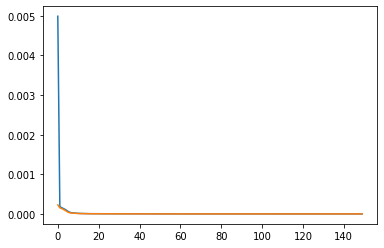

In [18]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.plot(loss)
plt.plot(val_loss)

## Save model

In [19]:
model_name = "ann_pos_23Apr_1"
save_model_with_scalers_binary(model, scaler_x, scaler_y, model_name)

INFO:tensorflow:Assets written to: ram://53bd600c-f112-4263-9734-57eaf3d1748d/assets


2022-04-23 20:48:48.768249: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


# Model tasting

In [ ]:
def plot_model_prediction(real_xy_pos, pred_xy_pos):
    real_xy_pos = np.round(real_xy_pos, decimals=3)
    real_xy_pos = np.round(real_xy_pos, decimals=3)
    real_xy_pos_without_zeros = real_xy_pos.copy()
    real_xy_pos_without_zeros[real_xy_pos_without_zeros == 0] = 1
    approximation_error = (100 * (np.absolute(pred_xy_pos - real_xy_pos) / np.absolute(real_xy_pos_without_zeros)).mean(axis=0))[0]
    print(f"approximation_error: {approximation_error}")
    
    plt.figure(figsize =(10, 5))
    plt.plot(pred_xy_pos[:, 0].reshape(-1, 1))
    plt.plot(real_xy_pos[:, 0].reshape(-1, 1))

    plt.show()

    plt.figure(figsize =(10, 5))
    plt.plot(pred_xy_pos[:, 1].reshape(-1, 1))
    plt.plot(real_xy_pos[:, 1].reshape(-1, 1))

    plt.show()

In [ ]:
def test_model_prediction(model: tf.keras.Model,
                          scaler_x: MinMaxScaler,
                          scaler_y: MinMaxScaler, 
                          record_file_name: str) -> None:
  recording_path = os.path.join(DATA_FOLDER_PATH, record_file_name)
  x_df, real_xy_pos_step = load_flight_steps_from_file(recording_path, INPUT_COLUMNS, OUTPUT_COLUMNS)
  real_xy_pos_step = real_xy_pos_step.to_numpy()

  data_x = scaler_x.transform(x_df)
  pred_y = model.predict(data_x)
  pred_xy_pos_step = scaler_y.inverse_transform(pred_y)

  real_xy_pos = np.add.accumulate(real_xy_pos_step)
  pred_xy_pos = np.add.accumulate(pred_xy_pos_step)

  plot_model_prediction(real_xy_pos, pred_xy_pos)

2022-04-21 19:01:53.992120: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-21 19:01:54.018534: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-21 19:01:54.019066: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-21 19:01:54.020120: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

approximation_error: 0.24779930351874455


2022-04-21 19:01:55.165863: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


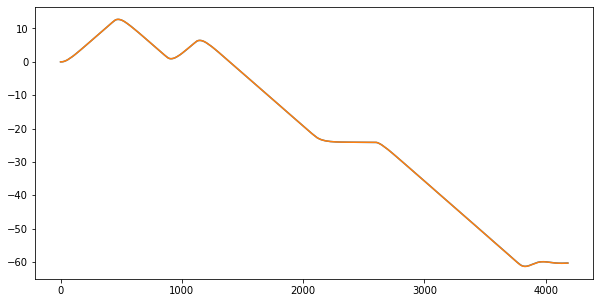

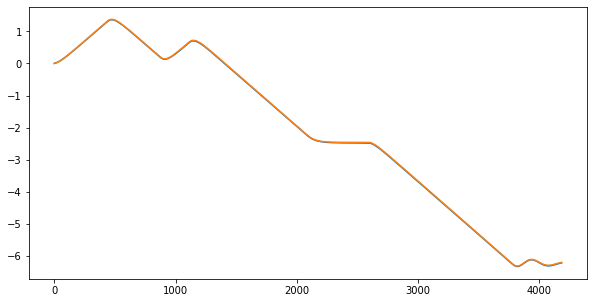

In [ ]:
record_file_name = "bot-simplified-2_09Apr_16:04_record.csv"

model_name = "ann_pos_1"
model, scaler_x, scaler_y = load_model_with_scalers_binary(model_name)
test_model_prediction(model, scaler_x, scaler_y, record_file_name)   

# Position prediction testing (without velocity)

In [22]:
recording_file_name = "bot-train-1_23Apr_18:24_record.csv"  
# recording_file_name = "bot-simplified-4_22Apr_22:10_record.csv"
recording_path = os.path.join(DATA_FOLDER_PATH, recording_file_name)

In [23]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

## different models

### b2zp

In [24]:
b2zp_model_name = "18Apt_14_08"
b2zp_input_columns = ["barometer_altitude", "barometer_pressure"]
b2zp_output_columns = ["position_z"]

def load_b2zp_data_from_file(csv_path: str):
    """

    @param csv_path:
    @param input_columns:
    @param output_columns:
    @return:
    """

    if not csv_path.endswith("csv"):
        raise ValueError(f"File with unsupported extension, expected csv (file: {csv_path})")

    flight_df = pd.read_csv(csv_path)

    x_df = flight_df[b2zp_input_columns].copy()
    x_df[b2zp_input_columns] = x_df[b2zp_input_columns].ewm(span=20, adjust=False).mean()

    y_df = flight_df[b2zp_output_columns].copy()

    
    return x_df, y_df

### ann o2s

In [25]:
def plot_model_prediction_speed(real_xy_speed, pred_xy_speed):
    real_xy_speed = np.round(real_xy_speed, decimals=3)
    pred_xy_speed = np.round(pred_xy_speed, decimals=3)
    real_xy_speed_without_zeros = real_xy_speed.copy()
    real_xy_speed_without_zeros[real_xy_speed_without_zeros == 0] = 1
    approximation_error = (100 * (np.absolute(pred_xy_speed - real_xy_speed) / np.absolute(real_xy_speed_without_zeros)).mean(axis=0))[0]
    print(f"approximation_error: {approximation_error}")
    
    plt.figure(figsize =(10, 5))
    plt.plot(pred_xy_speed[:, 0].reshape(-1, 1))
    plt.plot(real_xy_speed[:, 0].reshape(-1, 1))

    plt.show()

    plt.figure(figsize =(10, 5))
    plt.plot(pred_xy_speed[:, 1].reshape(-1, 1))
    plt.plot(real_xy_speed[:, 1].reshape(-1, 1))

    plt.show()

In [26]:
o2s_model_mame = "ann_o2s_23Apr_1"

ORIENTATION_SENSORS = ["orientation_x", "orientation_y", "orientation_z", "orientation_w"]
ANGULAR_VELOCITY_SENSORS = ["angular_velocity_x", "angular_velocity_y"]
LINEAR_ACCELERATION_SENSORS = ["linear_acceleration_x", "linear_acceleration_y"]
ANGULAR_ACCELERATION_SENSORS = [ "angular_acceleration_x", "angular_acceleration_y"]

o2s_input_columns = [*ORIENTATION_SENSORS, *LINEAR_ACCELERATION_SENSORS]
o2s_output_columns = ["linear_velocity_x", "linear_velocity_y"]

def load_o2s_data_from_file(csv_path: str):
    """

    @param csv_path:
    @return:
    """
    if not csv_path.endswith("csv"):
        raise ValueError(f"File with unsupported extension, expected csv (file: {csv_name})")

    flight_df = pd.read_csv(csv_path)
    
    x_df = flight_df[o2s_input_columns].copy()

    next_df = x_df[ORIENTATION_SENSORS].shift(-1)
    orientaion_diff = (next_df - x_df[ORIENTATION_SENSORS])
    orientaion_diff.rename(columns={key : f"{key}_diff" for key in orientaion_diff.columns}, inplace=True)

    y_df = flight_df[o2s_output_columns].copy()
    

    # Drops the last record because the process is based of difference
    x_df.drop(x_df.tail(1).index, inplace=True)
    y_df.drop(y_df.tail(1).index, inplace=True)

    x_df = pd.concat([x_df, orientaion_diff[:-1]], axis=1)

    return x_df, y_df

## Implementation

In [27]:
o2s_model, o2s_scaler_x, o2s_scaler_y = load_model_with_scalers_binary(o2s_model_mame)

orientation_df, speed_df = load_o2s_data_from_file(recording_path)
processed_orientaion = o2s_scaler_x.transform(orientation_df)
pred_processed_speed = o2s_model(processed_orientaion)
pred_speed = o2s_scaler_y.inverse_transform(pred_processed_speed)
pred_speed[:, 0] = savgol_filter(pred_speed[:, 0], 189,3, mode='mirror')
pred_speed[:, 1] = savgol_filter(pred_speed[:, 1], 189,3, mode='mirror')
# plot_model_prediction_speed(speed_df.to_numpy(), pred_speed)

b2zp_model, b2zp_scaler_x, b2zp_scaler_y = load_model_with_scalers_binary(b2zp_model_name)
barometer_df, position_z_df = load_b2zp_data_from_file(recording_path)

processed_barometer = b2zp_scaler_x.transform(barometer_df)
pred_processed_z_pos_offset = b2zp_model(processed_barometer)
pred_z_pos_offset = b2zp_scaler_y.inverse_transform(pred_processed_z_pos_offset)

ann_pos_model_name = "ann_pos_1"
ann_pos_model, ann_pos_scalery_x, ann_pos_scaler_y = load_model_with_scalers_binary(ann_pos_model_name)

data_x, real_zy_pos_steps = load_flight_steps_from_file(recording_file_name, INPUT_COLUMNS, OUTPUT_COLUMNS)
data_x[o2s_output_columns] = pred_speed
                                                                                
processed_data = ann_pos_scalery_x.transform(data_x)
pred_processed_zy_pos_steps = ann_pos_model(processed_data)
pred_zy_pos_steps = ann_pos_scaler_y.inverse_transform(pred_processed_zy_pos_steps)                                        
pred_zy_pos_offset = np.add.accumulate(pred_zy_pos_steps)

pred_pos_offset = np.hstack([pred_zy_pos_offset, pred_z_pos_offset[:-1]])

real_zy_pos_offset = np.add.accumulate(real_zy_pos_steps)
real_pos_offset = np.hstack([real_zy_pos_offset, position_z_df.to_numpy()[:-1]])

In [28]:
print(pred_pos_offset)
print(real_pos_offset)

[[-6.62368884e-03 -2.09454502e-03 -1.02537168e+02]
 [-1.32251974e-02 -4.18643042e-03 -1.02528597e+02]
 [-2.10922721e-02 -6.65495147e-03 -1.02549258e+02]
 ...
 [ 2.75391872e+01 -2.62494352e+01 -1.04924683e+02]
 [ 2.75395860e+01 -2.62504387e+01 -1.04910347e+02]
 [ 2.75400844e+01 -2.62516406e+01 -1.04922555e+02]]
[[ 0.00000000e+00  0.00000000e+00 -1.02411255e+02]
 [ 0.00000000e+00  0.00000000e+00 -1.02411026e+02]
 [ 3.05175781e-05  0.00000000e+00 -1.02410797e+02]
 ...
 [ 2.51489868e+01 -2.31758728e+01 -1.04944038e+02]
 [ 2.51489868e+01 -2.31758728e+01 -1.04943993e+02]
 [ 2.51489868e+01 -2.31758728e+01 -1.04943954e+02]]


## Graphs

approximation_error: 9.624836570138909


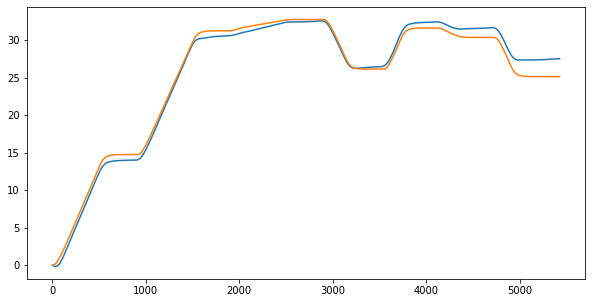

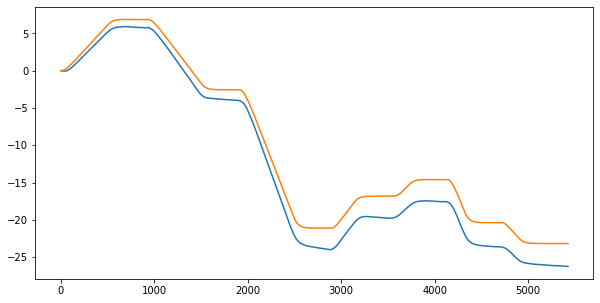

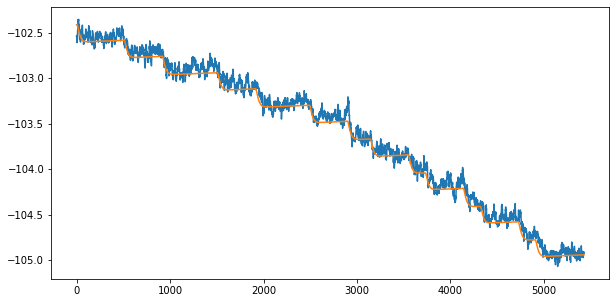

In [29]:
pred_xyz_offset = np.round(pred_pos_offset, decimals=3)
real_xyz_offset = np.round(real_pos_offset, decimals=3)
real_xyz_offset_without_zeros = real_xyz_offset.copy()
real_xyz_offset_without_zeros[real_xyz_offset_without_zeros == 0] = 1
approximation_error = (100 * (np.absolute(pred_xyz_offset - real_xyz_offset) / np.absolute(real_xyz_offset_without_zeros)).mean(axis=0))[0]
print(f"approximation_error: {approximation_error}")

plt.figure(figsize =(10, 5))
plt.plot(pred_xyz_offset[:, 0].reshape(-1, 1))
plt.plot(real_xyz_offset[:, 0].reshape(-1, 1))

plt.show()

plt.figure(figsize =(10, 5))
plt.plot(pred_xyz_offset[:, 1].reshape(-1, 1))
plt.plot(real_xyz_offset[:, 1].reshape(-1, 1))

plt.show()


plt.figure(figsize =(10, 5))
plt.plot(pred_xyz_offset[:, 2].reshape(-1, 1))
plt.plot(real_xyz_offset[:, 2].reshape(-1, 1))

plt.show()

In [30]:
pred_pos_offset.shape

(5428, 3)

In [31]:
def plot_model_prediction(real_xy_speed, pred_xy_speed):
    real_xy_speed = np.round(real_xy_speed, decimals=3)
    real_xy_speed = np.round(real_xy_speed, decimals=3)
    real_xy_speed_without_zeros = real_xy_speed.copy()
    real_xy_speed_without_zeros[real_xy_speed_without_zeros == 0] = 1
    approximation_error = (100 * (np.absolute(pred_xy_speed - real_xy_speed) / np.absolute(real_xy_speed_without_zeros)).mean(axis=0))[0]
    print(f"approximation_error: {approximation_error}")
    
    plt.figure(figsize =(10, 5))
    plt.plot(pred_xy_speed[:, 0].reshape(-1, 1))
    plt.plot(real_xy_speed[:, 0].reshape(-1, 1))

    plt.show()

    plt.figure(figsize =(10, 5))
    plt.plot(pred_xy_speed[:, 1].reshape(-1, 1))
    plt.plot(real_xy_speed[:, 1].reshape(-1, 1))

    plt.show()

In [32]:
def test_model_prediction(s2p_model: tf.keras.Model,
                          b2p_model: tf.keras.Model, 
                          o2s_model: tf.keras.Model,
                          scaler_x: MinMaxScaler,
                          scaler_y: MinMaxScaler, 
                          record_file_name: str) -> None:



  x_df, real_xy_speed = load_flight_steps_from_file(recording_path, INPUT_COLUMNS, OUTPUT_COLUMNS)
  real_xy_speed = real_xy_speed.to_numpy()

  data_x = scaler_x.transform(x_df)
  pred_y = model.predict(data_x)
  pred_xy_speed = scaler_y.inverse_transform(pred_y)

  plot_model_prediction(real_xy_speed, pred_xy_speed)

# Hyperparameters tuning

### Model Creation

In [ ]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [ ]:
def create_dynamic_model(hp: kt.HyperParameters) -> Model:
    """
    Creates Sequence model dynamically
    :param hp: Hyper parameters (Initialized by a tuning algorithm)
    :return:
    """
    model = Sequential()
    model.add(layers.Input(shape=(hp.get("input_columns_amount"))))    
    activation = hp.Choice("dense_actiavtion", ["tanh", "relu", "sigmoid"])
    dense_layers = hp.Int("dense_layers", min_value=1, max_value=4)

    for layer_id in range(dense_layers):
      layer_units = hp.Int(f"dense_{layer_id}_units", min_value=16, max_value=256, step=16)

      model.add(layers.Dense(layer_units,
                             activation=activation,
                             kernel_regularizer=keras.regularizers.L2(
                                 hp.Choice(f"l2_regulator_{layer_id}", [0.0, 0.1, 0.01, 0.001]))))

      dropout_rate = hp.Float(f"dense_{layer_id}_dropout_rate", min_value=0, max_value=0.4, step=0.05)
      model.add(layers.Dropout(dropout_rate))

    model.add(layers.Dense(hp.get("output_columns_amount")))

    learning_rate = hp.Choice("adam_learning_rate", [0.01, 0.001, 0.002, 0.005])

    if hp.Boolean(f"learning_rate_decay"):
        learning_rate = optimizers.schedules.ExponentialDecay(
            initial_learning_rate=learning_rate,
            decay_steps=10000,
            decay_rate=0.9)

    model.compile(loss='mean_squared_error',
                  optimizer=optimizers.Adam(learning_rate=learning_rate))

    return model



### The Tuner



In [ ]:
hp = kt.HyperParameters()
hp.Fixed("input_columns_amount", len(INPUT_SEQUENCE_COLUMNS))
hp.Fixed("output_columns_amount", len(OUTPUT_SEQUENCE_COLUMNS))

project_name = "ann_12MarNight_position_with_regularizator"
tuner = kt.BayesianOptimization(
    create_dynamic_model,
    hyperparameters=hp,
    objective="val_loss",
    max_trials=1000,
    directory=TUNERS_FOLDER_PATH,
    project_name=project_name,
    executions_per_trial = 1
)

INFO:tensorflow:Reloading Oracle from existing project /home/israzex/Desktop/drone_homecoming_rl/artificial_gps/tuners/ann_12MarNight_position_with_regularizator/oracle.json


In [ ]:
# tuner.get_best_hyperparameters()[0].values

In [ ]:
model = tuner.get_best_models()[0]
model_name = "position_best_11Mar_1"
save_model_with_scalers_binary(model, scaler_x, scaler_y, model_name)

569
441
16
INFO:tensorflow:Assets written to: ram://1ecd14e5-e86f-49e7-8616-9c7d73d12757/assets


2022-03-11 14:29:09.105149: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


### Truning

In [ ]:
tensorboard_dir = os.path.join(os.path.join(TUNERS_FOLDER_PATH,project_name), "tensorboard")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tensorboard_dir, 
                                                      histogram_freq=1)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, baseline=0.00001)
tuner.search(train_x,
            train_y,
             validation_data=(dev_x, dev_y),
             epochs = 2000,
             batch_size=512,
             callbacks=[early_stop, tensorboard_callback])



# Position Test


In [ ]:
                          
POISITON_INPUT_COLUMNS = ["linear_velocity_x", "linear_velocity_y", "linear_velocity_z",
                          "angular_acceleration_x", "angular_acceleration_y", "angular_acceleration_z",
                          "linear_acceleration_x", "linear_acceleration_y", "linear_acceleration_z",
                          "angular_velocity_x", "angular_velocity_y", "angular_velocity_z",
                          "orientation_x", "orientation_y", "orientation_z", "orientation_w", "motor_state_timestamp",
                          "barometer_altitude", "barometer_pressure", 
                          "barometer_qnh", 
                          "barometer_timestamp",                          
                          "magnetometer_magnetic_field_body_x", "magnetometer_magnetic_field_body_y",
                          "magnetometer_magnetic_field_body_z", "magnetometer_timestamp",
                          "rotor_a_speed", "rotor_a_thrust", "rotor_a_torque_scaler",
                          "rotor_b_speed", "rotor_b_thrust", "rotor_b_torque_scaler",
                          "rotor_c_speed", "rotor_c_thrust", "rotor_c_torque_scaler",
                          "rotor_d_speed", "rotor_d_thrust", "rotor_d_torque_scaler",
                          "rotor_timestamp"
                         ]
POISITON_OUTPUT_COLUMNS = ["position_x", "position_y", "position_z"]

SPEED_INPUT_COLUMNS = ["angular_acceleration_x", "angular_acceleration_y", "angular_acceleration_z",
                          "linear_acceleration_x", "linear_acceleration_y", "linear_acceleration_z",
                          "angular_velocity_x", "angular_velocity_y", "angular_velocity_z",
                          "orientation_x", "orientation_y", "orientation_z", "orientation_w", "motor_state_timestamp",
                          "barometer_altitude", "barometer_pressure", 
                          "barometer_qnh", 
                          "barometer_timestamp",                          
                          "magnetometer_magnetic_field_body_x", "magnetometer_magnetic_field_body_y",
                          "magnetometer_magnetic_field_body_z", "magnetometer_timestamp",
                          "rotor_a_speed", "rotor_a_thrust", "rotor_a_torque_scaler",
                          "rotor_b_speed", "rotor_b_thrust", "rotor_b_torque_scaler",
                          "rotor_c_speed", "rotor_c_thrust", "rotor_c_torque_scaler",
                          "rotor_d_speed", "rotor_d_thrust", "rotor_d_torque_scaler",
                          "rotor_timestamp"
                         ]
SPEED_OUTPUT_COLUMNS = ["linear_velocity_x", "linear_velocity_y", "linear_velocity_z"]


FLIGHT_DATA_CSV_NAME = "manual_31Jan_00:43_record.csv"

In [ ]:
speed_model_name = "ann_speed_13Mar_best"
position_model_name = "ann_13Mar22_best"




try:
    speed_model, speed_scaler_x, speed_scaler_y = load_model_with_scalers_binary(speed_model_name)
    position_model, position_scaler_x, position_scaler_y = load_model_with_scalers_binary(position_model_name)
except FileNotFoundError:
    print(f"There is no model with name {speed_model_name} or {position_model_name}")

# Predicts velocity
flight_x_df, flight_y_df = load_flight_steps_from_file(FLIGHT_DATA_CSV_NAME, SPEED_INPUT_COLUMNS, SPEED_OUTPUT_COLUMNS)
copyed_x_df = flight_x_df.copy()
data_x = speed_scaler_x.transform(copyed_x_df)
data_x = data_x.astype(np.float32)

predicted_y = speed_model.predict(data_x)
predicted_y = speed_scaler_y.inverse_transform(predicted_y)

real_y = flight_y_df.to_numpy()
target_predicted_velocity = np.add.accumulate(predicted_y)
real_velocity = np.add.accumulate(real_y)

for record in zip(predicted_y, real_y):
  print(record)

for record in zip(target_predicted_velocity, real_velocity):
  print(record)

# Predicts position based on velocity 
flight_pos_x_df, flight_y_df = load_flight_steps_from_file(FLIGHT_DATA_CSV_NAME, POISITON_INPUT_COLUMNS, POISITON_OUTPUT_COLUMNS)

flight_x_df.insert(0, "linear_velocity_z", target_predicted_velocity[:,2])
flight_x_df.insert(0, "linear_velocity_y", target_predicted_velocity[:,1])
flight_x_df.insert(0, "linear_velocity_x", target_predicted_velocity[:,0])
copyed_x_df = flight_x_df.copy()

time_intervals = flight_pos_x_df[MAIN_TIMESTAMP_COLUMN].to_numpy().reshape(-1, 1)

data_x = position_scaler_x.transform(flight_pos_x_df)
data_x = data_x.astype(np.float32)

real_y = flight_y_df.to_numpy()
predicted_y = position_model.predict(data_x)
predicted_y = position_scaler_y.inverse_transform(predicted_y)

time_offset = np.add.accumulate(time_intervals)
predicted_offset = np.add.accumulate(predicted_y)
real_offset = np.add.accumulate(real_y)

time_stamps_to_print = list(range(10))
time_stamps_to_print.extend([15, 20, 25, 30, 40, 50, 100])
index = 0



In [ ]:
for predicted, real, time_offset in zip(predicted_offset, real_offset, time_offset):
    if index < len(time_stamps_to_print) and \
            int(time_offset) == time_stamps_to_print[index]:
        print(
            f"position:\nreal offset:      {real}\npredicted offset: {predicted}\ntime offset(seconds): {time_offset}\n\n")
        index += 1

